### Temporal Plot of Raw Data

In [1]:
import os, csv, pickle, gzip, torch
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R


#========= read =========================================================================
# features(ffile):   return [trimX, trimY, trimAnimTs, trimGTPos, trimHmdTs, trimHmd1Ts, trimEyeTs, self.l_trim_idx]
# sorted_params(sfile):  (row=subject) (column=file_num)
# df_files(dffile): (param df data for all subject, file pairs)
# 	sub_idx	file_idx	is_exclude	start_idx	end_idx	length	h	v	d	x	y	z
def read_gzip(path):    
    # All VERSIONs should match (pickle, python, pandas)
    output = []
    assert os.path.exists(path), 'ReadGzip Assertion: path is null: {0}'.format(path)
    with gzip.open(path, 'rb') as file:
        print("open gzip")
        output = pickle.load(file)     
    return output


# spath = "data/data_feature/sorted-params.csv"
# sfile = open(spath, 'r', encoding='utf-8')
# sfile = list(csv.reader(sfile))

# file_name = "0814-f18"
# fpath = "data/data_feature/" + file_name + ".gz"
# ffile = read_gzip(fpath)

dfpath = "data/data_feature/0216-df.csv"
dffile = pd.read_csv(dfpath, na_values=" NaN").dropna(how='all', axis=1)
dffile = dffile[['sub_idx','file_idx','length', 'h','v','d']]
# print(dffile.head)

params_df = dffile[['h','v','d']]
params_tensor = torch.tensor(params_df.values, dtype=torch.float32)
PARAMS = params_tensor.reshape(24, 144, 3)
# print(PARAMS[0])

In [131]:
#========= temporal plot functions =========================================================================

%matplotlib notebook
%matplotlib inline
from tqdm import tqdm
from functools import partial
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import rc
import matplotlib.cm as cm
from matplotlib.collections import LineCollection


#X for subject= [144, 20, 9]. For each Joint,
#==== TS =============================================
#(HMD, lhand, rhand, index) 
#(e1, e2) **e0 was combined eye and not included 
#(efrch, efrc1, efrc2) 
#(vecprod: e1*efrch, e2*efrch, e1*efrc1, e2*efrc2)
#==== Delta TS =============================================
#(HMD, lhand, rhand, index) 
#(e1, e2) **e0 was combined eye and not included 
#(efrch, efrc1, efrc2) 
#(vecprod: e1*efrch, e2*efrch, e1*efrc1, e2*efrc2)


def calc_meta_data(dffile):
    # https://note.nkmk.me/en/python-pandas-multiple-conditions/#select-rows-by-multiple-conditions
    """
    dffile = pd of ['sub_idx','file_idx','length', 'h','v','d']
    
    1. use sub(0-15)
    2. isolate by 36 combinations
    3. find mean avg / std for length
    """
    # ===== plot by combination ===========
    df = dffile.loc[ dffile['sub_idx']<16]
    df_combination = pd.DataFrame()
    plt.figure()
    plt.title("Task-time distribution per target position")
    print("#Files // Mean_l // Min_l // Max_l // STD" )
    for cIdx in range(36):
        v1, v2, v3, v4 = cIdx, 36+cIdx, 72+cIdx, 108+cIdx
        df_comb = df.loc[ (df['file_idx'] == v1) | (df['file_idx'] ==v2) | (df['file_idx'] == v3) | (df['file_idx'] == v4)]
        df_comb = df_comb.loc[df_comb['length'] > -1]
        col_name = 'c' + str(cIdx)
        df_comb_length = df_comb['length']
        # print(df_comb_length.shape[0], "//", round(df_comb_length.mean(),2), "/", round(df_comb_length.min(),2), "/", round(df_comb_length.max(),2), "/", round(df_comb_length.std(),2))
        
        ax = df_comb_length.plot.kde()
        ax.set_xlabel('frames')    
    
    # ===== plot by subject ===========
    df = dffile        
    plt.figure()
    plt.title("Task-time distribution per subject")
    print("#Files // Mean_l // Min_l // Max_l // STD" )        
    for sIdx in range(24):
        df_sub = df.loc[ (df['sub_idx'] == sIdx) ]
        df_sub = df_sub.loc[df_sub['length'] > -1]
        df_sub_length = df_sub['length']
        # print(sIdx, "//", round(df_sub_length.mean(),2), "/", round(df_sub_length.min(),2), "/", round(df_sub_length.max(),2), "/", round(df_sub_length.std(),2))    
        
        ax = df_sub_length.plot.kde()
        ax.set_xlabel('frames')
    
    
    
        
        
def PlotProgInMilisecs(ffile, sfile, PARAMS):
    """
    ffile = feature file for subject
    sfile = pointer idx file
    PARAMS = parameter file for all sub sessions
            
    #1. For 16 subjects, divide by 36 combinations.
    #2. Results in (16*4)progression for each combinations
    #3. Find longest progression frame for each combination
    #4. Resample to wanted sampling rate
    #5. Average for each data point til the longest file frame
    #6. Plot all 36 combinations or plot for different depth, angle values.
    #7. try to find visual deviance
    """
    
    # =====Input Feature Index to Plot ==================
    print( "jidx:(0,1,2,3)=(Hmd,lh,rh,rindex), (4,5,6,7,8)=(e1,e2,efrch,efrc1,efrc2), (9)=(vecprod)" )
    print("jidx velocity:(10,11,12,13), (14,15,16,17,18), (19)")
    feature_idx = int(input("jIdx to Plot: "))
          
    # =====START LOOP (file -> subject ==================
    fig, (ax) = plt.subplots(1,1)
    fig.set_size_inches(8,8)
    plt.title("Prog-MiliSeconds")
    for fIdx in tqdm(range(144)):

        for sIdx in range(16):
            pIdx = int(sfile[sIdx][fIdx]) #pointer idx
            param = PARAMS[sIdx][pIdx]
            X = ffile[sIdx][0] #[144][:endframes,4,4]
            F = X[:,feature_idx]
            # V_linear = 
            # V_angular = 

                
                
          
          
    
    
          
    






#Files // Mean_l // Min_l // Max_l // STD
#Files // Mean_l // Min_l // Max_l // STD


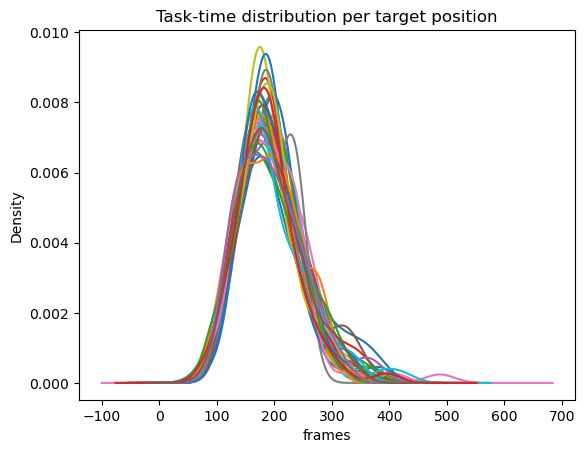

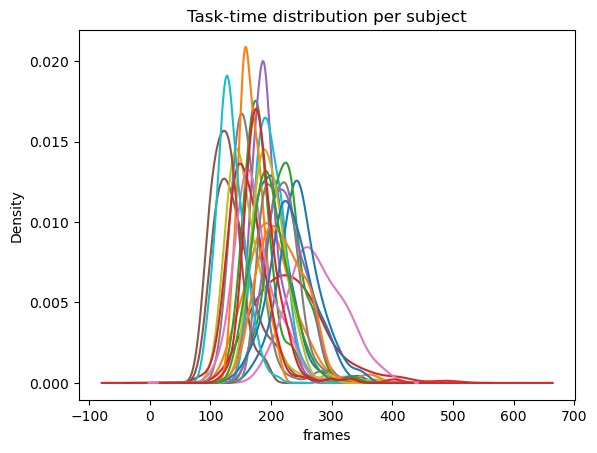

In [132]:
calc_meta_data(dffile)

In [ ]:
# https://www.youtube.com/watch?v=4I2ifomFOec
# https://stackoverflow.com/questions/71916767/how-to-plot-confidence-interval-of-a-time-series-data-in-python
# to plot 95% confidence intervals you need to account for 2*sigma range

# ONE GRAPH 95% confidence
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

mean, lower, upper = [],[],[]
c = 0.95
for i in range (20):
    a = np.random.rand(100) # this is the output
    m, ml, mu = mean_confidence_interval(a, c)
    mean.append(m)
    lower.append(ml)
    upper.append(mu)

plt.figure()
plt.plot(mean,'-b', label='mean')
plt.plot(upper,'r:', label='upper')
plt.plot(lower,'g:', label='lower')
# fill the area with black color, opacity 0.15
plt.fill_between(list(range(len(mean))), upper, lower, color="k", alpha=0.15)

plt.xlabel("Value")
plt.ylabel("Loss")
plt.legend()